In [1]:
import os 
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

import torch 
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision.transforms import transforms

from InriaDataset import InriaDataset
from polyModel import YOLOV5m

In [2]:
class config:
    # import torch

    # Pre-training
    nc= 1
    labels = ['House']
    IMAGE_SIZE = 1024
    FIRST_OUT = 24
    ch=(FIRST_OUT*4, FIRST_OUT*8, FIRST_OUT*16)
    image_height = IMAGE_SIZE
    image_width = IMAGE_SIZE
    MANUAL_SEED = 32

    ANCHORS = [
        [(10, 13), (16, 30), (33, 23)],  # P3/8
        [(30, 61), (62, 45), (59, 119)],  # P4/16
        [(116, 90), (156, 198), (373, 326)]  # P5/32#
    ]

    CLS_PW = 1.0
    OBJ_PW = 1.0

    HOUSE_GRID = 64
    BLOCK_GRID = 32

    # Training
    TRAIN_TRANSFORMS = torchvision.transforms.Resize((image_width, image_height), antialias=False)
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 5e-4
    pin_memory=True
    BATCH_SIZE = 2
    epochs = 250

    # Post-training
    SAVE_MODEL=False
    CONF_THRESHOLD = 0.01  # to get all possible bboxes, trade-off metrics/speed --> we choose metrics
    NMS_IOU_THRESH = 0.6
    # for map 50
    MAP_IOU_THRESH = 0.5

    # others
    COCO = labels


In [3]:
class BaseLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.mse = nn.MSELoss()
        self.labmda_obj = 1
        self.labmda_points = 1

    def forward(self, pred, target):
        objs_true = target[..., :1].to(config.DEVICE)
        objs_pred = pred[..., :1]
        points_true = target[..., 1:].to(config.DEVICE)
        points_pred = pred[..., 1:]

        # Objectness Loss
        obj_loss = self.bce(objs_pred, objs_true)

        # Points loss
        loss = self.mse(points_pred, points_true)

        return (
            obj_loss * self.labmda_obj
            + loss * self.labmda_points
        )

In [4]:
# Dataset
dataset = InriaDataset(base_dir='FinalDataset', transform=config.TRAIN_TRANSFORMS)
train_len = int(0.8 * len(dataset))
train_data, val_data = random_split(dataset, [train_len, len(dataset) - train_len], generator=torch.Generator().manual_seed(config.MANUAL_SEED))
dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
val_loader = DataLoader(val_data, batch_size=config.BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
print(f"Train Images: {len(train_data)} - Val Images: {len(val_data)}")

# Model
model =YOLOV5m(first_out=config.FIRST_OUT, nc=config.nc, anchors=config.ANCHORS, ch=config.ch).to(config.DEVICE)
params = sum(p.numel() for p in model.parameters())
print(f"Total trainable paramters are: {params:,}")

# Training Stuff
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
# scaler = torch.cuda.amp.GradScaler()

# Loss
critertion = BaseLoss()

Train Images: 80 - Val Images: 20
Total trainable paramters are: 5,247,393


In [5]:
def calc_midpoint(points):
    # Calculate the minimum and maximum coordinates
    min_x, min_y = np.min(points, axis=0)
    max_x, max_y = np.max(points, axis=0)

    # Calculate the midpoint of the bounding box
    midpoint = (min_x + max_x) / 2, (min_y + max_y) / 2

    return midpoint

def build_targets(polygons, image_size=1024, n_grids=64, B=3, normalize=True, poly_type="house"):
    assert poly_type in ['house', 'block'], f"poly_types must be in ['house', 'block'], got {poly_type}"

    cell_size = image_size // n_grids # Size of a cell
    half_cell = cell_size / 2
    bs = len(polygons)
    if poly_type == 'house':
        targets = np.zeros((bs, B, n_grids, n_grids, 9), dtype=np.float32)
    else:
        targets = np.zeros((bs, B, n_grids, n_grids, 17), dtype=np.float32)
    ## For Every box
    for idx, polys in enumerate(polygons):
        n_missing_boxes = 0
        n_total_boxes = polys.shape[0]

        for poly in polys:
            if poly_type == 'house':
                poly = poly[..., 1:-1].reshape(4, 2)
            else:
                poly = poly[..., 1:].reshape(8, 2)
            if normalize:
                poly = poly * image_size

            # Calculate the mid point of the box
            mid = calc_midpoint(poly)
            # Calculate the ij of the box
            cell_index = (int(mid[0] / cell_size), int(mid[1] / cell_size))
            obj_arr = targets[idx, :, cell_index[0], cell_index[1], 0]
            empty_box_idx = next((i for i, x in enumerate(obj_arr) if x == 0), -1)

            if empty_box_idx != -1:

                targets[idx, empty_box_idx, cell_index[0], cell_index[1], 0] = 1 # Add Object flag to 1

                # Convert the ij into cell midpoint coords
                cell_midpoint_coords = (cell_index[0] * cell_size + half_cell, cell_index[1] * cell_size + half_cell)

                # Calculate the relative position of the box wrt cell center
                relative_box_coords = poly - cell_midpoint_coords

                # Assign Box Coords to target
                targets[idx, empty_box_idx, cell_index[0], cell_index[1], 1:] = relative_box_coords.flatten() # Add Object

            else:
                n_missing_boxes += 1

    # print(f"Total Number of Missing Boxes are: {n_missing_boxes}/{n_total_boxes}")
    return torch.from_numpy(targets)


def visualize_target_tensor(mask, targets, show_midpoint=False, show_grid=False, obj_logits=False, title=None):
    # Image
    n_grids = targets.shape[-2]
    boxes = targets.shape[-4]
    _, w, h = mask.shape
    cell_size = w // n_grids
    half_cell = cell_size // 2
    plt.imshow(mask.permute(1,2,0))
    if show_grid:
        plt.xticks(np.arange(0, w, w//n_grids))  # Adjut the value for x and y a needed
        plt.yticks(np.arange(0, h, h//n_grids))
        plt.grid()

    # points
    for b in range(boxes):
        for i in range(n_grids):
            for j in range(n_grids):
                obj = targets[b, i, j, 0]
                if obj_logits:
                    obj = obj.sigmoid() # To convert the pred obj
                if obj > 0.5:
                    cell_midpoint_coords = torch.tensor((i * cell_size + half_cell, j * cell_size + half_cell))
                    points = targets[b, i, j, 1:].reshape(-1, 2)
                    points = points + cell_midpoint_coords

                    if show_midpoint: plt.scatter(cell_midpoint_coords[0], cell_midpoint_coords[1])
                    plt.scatter(points[:, 0], points[:, 1], s=12)

    if title:
        plt.title(title)

    plt.plot()

In [6]:
def fit_single_batch(iters, model, data, loss_fn, optimizer):
    # Implemented For houses only
    images, houses, blocks = data
    images = images.to(config.DEVICE)

    loss_list = []
    house_targets = build_targets(houses).to(config.DEVICE)
    block_targets = build_targets(blocks, poly_type='block', n_grids=32).to(config.DEVICE)

    pbar = tqdm(range(iters), total=iters, desc="Training")

    for i in pbar:
        optimizer.zero_grad()

        out = model(images)
        _, house_pred, block_pred = out
        house_loss = loss_fn(house_pred, house_targets)
        block_loss = loss_fn(block_pred, block_targets)

        total_loss = house_loss + block_loss

        total_loss.backward()
        optimizer.step()

        pbar.set_postfix({"Loss": total_loss.item()})

        loss_list.append(total_loss.item())

    return loss_list

In [7]:
def train_one_epoch(n_epochs=config.epochs, model=model, dataloader=dataloader, loss_fn=critertion, optimizer=optimizer, verbose=True):
    loss_list = []
    model.train()

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Training", disable=not verbose)

    for idx, (images, houses, blocks) in pbar:
        optimizer.zero_grad()

        # Peprocessing data 
        images = images.to(config.DEVICE)
        house_targets = build_targets(houses).to(config.DEVICE)
        block_targets = build_targets(blocks, poly_type='block', n_grids=32).to(config.DEVICE)

        # Forward Pass
        out = model(images)
        _, house_pred, block_pred = out
        house_loss = loss_fn(house_pred, house_targets)
        block_loss = loss_fn(block_pred, block_targets)

        # Calc Loss and Backprop
        total_loss = house_loss + block_loss

        total_loss.backward()
        optimizer.step()

        pbar.set_postfix({"Loss": total_loss.item()})
        loss_list.append(total_loss.item())

    return loss_list


def validate_one_epoch(n_epochs=config.epochs, model=model, dataloader=val_loader, loss_fn=critertion, verbose=True):
    loss_list = []
    model.eval()

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Validation", disable=not verbose)

    for idx, (images, houses, blocks) in pbar:
        # Peprocessing data 
        images = images.to(config.DEVICE)
        house_targets = build_targets(houses).to(config.DEVICE)
        block_targets = build_targets(blocks, poly_type='block', n_grids=32).to(config.DEVICE)

        # Forward Pass
        out = model(images)
        _, house_pred, block_pred = out
        house_loss = loss_fn(house_pred, house_targets)
        block_loss = loss_fn(block_pred, block_targets)

        # Calc Loss and Backprop
        total_loss = house_loss + block_loss

        pbar.set_postfix({"Loss": total_loss.item()})
        loss_list.append(total_loss.item())

    return loss_list


In [8]:
# Main loss 

# train_loss_list = []
# val_loss_list = []
# for epoch in range(config.epochs):
#     print("="*8, f" {epoch+1} / {config.epochs} ", "="*8)
#     train_loss = train_one_epoch()
#     val_loss = validate_one_epoch()

#     train_loss_list.append(np.mean(train_loss))
#     val_loss_list.append(np.mean(val_loss))
#     print(f"Training Loss: {np.mean(train_loss):.6f} - Validation Loss: {np.mean(val_loss):.6f}")


In [9]:
# minmal Version
train_loss_list = []
val_loss_list = []

pbar = tqdm(range(config.epochs), total=config.epochs, desc="Training Iterations")
for epoch in pbar:
    # print("="*8, f" {epoch+1} / {config.epochs} ", "="*8)
    train_loss = train_one_epoch(verbose=False)
    val_loss = validate_one_epoch(verbose=False)

    train_loss_list.append(np.mean(train_loss))
    val_loss_list.append(np.mean(val_loss))
    # print(f"Training Loss: {np.mean(train_loss):.6f} - Validation Loss: {np.mean(val_loss):.6f}")
    pbar.set_postfix({"Training Loss": np.mean(train_loss), "Validation Loss": np.mean(val_loss)})


Training Iterations: 100%|██████████| 250/250 [37:00<00:00,  8.88s/it, Training Loss=0.329, Validation Loss=11.2]


In [10]:
# Save Results
save_dir = f'saves/{config.epochs}/'
os.makedirs(save_dir, exist_ok=True)
np.save(os.path.join(save_dir, "train_loss_list.npy"), train_loss_list)
np.save(os.path.join(save_dir, "val_loss_list.npy"), val_loss_list)


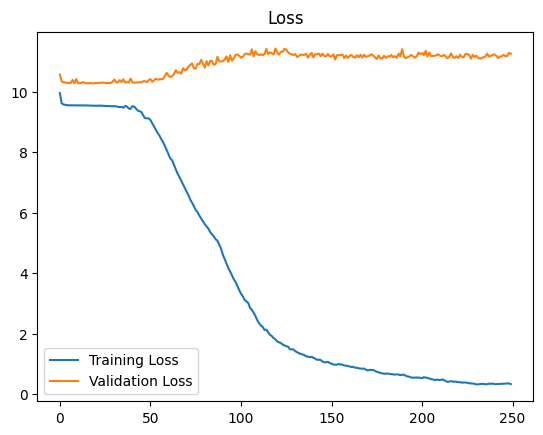

In [11]:

# Visualize
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.legend()
plt.title("Loss")
plt.show()

In [12]:
## Visulaize Some Results

images, houses, blocks = next(iter(dataloader))

with torch.no_grad():
    out =  model(images.to(config.DEVICE))

In [13]:
house_pred = out[1].cpu()
block_pred = out[2].cpu()

In [14]:
def count_obj_in_tensor(t):
    pred_shape = t.shape[-1]
    all_predictions = t.reshape(-1, pred_shape)
    obj_arr = all_predictions[..., :1]
    n_objs = ((obj_arr > 0.5).int()).sum()
    return n_objs

In [19]:
count_obj_in_tensor(build_targets(houses)[0])

tensor(290)

In [18]:
count_obj_in_tensor(house_pred[0])

tensor(282)

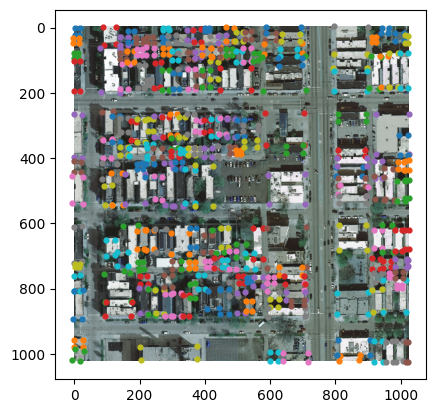

In [16]:
visualize_target_tensor(images[1], house_pred[1])

In [17]:
raise Exception("PPY")

Exception: PPY

Training Iterations: 100%|██████████| 300/300 [37:53<00:00,  7.58s/it, Loss=7.22e+4]


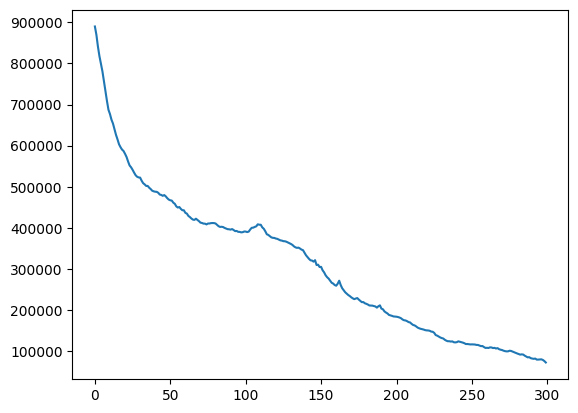

In [ ]:
## Overfit
iters = 300
try:
    total_loss_list = []
    pbar = tqdm(range(iters), total=iters, desc="Training Iterations")
    for idx in pbar:
        loss_list = train_one_epoch(verbose=False)
        total_loss_list.append(np.mean(loss_list))
        pbar.set_postfix({"Loss": np.mean(loss_list).item()})

except KeyboardInterrupt:
    pass


plt.plot(total_loss_list)
plt.show()  

np.save(f'saves/overfit_train_loss_{iters}iter.npy', total_loss_list)


In [ ]:
# Visualization
